# Project Title: PUBG Win Placement Prediction 
## Introduction & Goal
   This notebook documents the end-to-end Machine Learning pipeline for predicting the Win Placement Percentage (winPlacePerc) of players in PUBG matches.

The primary challenge lies in transforming individual player statistics into robust, highly predictive collective team features. The ultimate goal is to identify the most efficient team metrics and train a model capable of predicting final placement with minimal error.   
## Data Overview and Challenges
The pubg.csv is based on player statistics from the game PlayerUnknown's Battlegrounds (PUBG), sourced from a machine learning competition (often Kaggle). It is a complex, high-dimensional dataset that mixes individual performance metrics with game-level context.
Two major inherent challenges in the raw data defined the necessity of our extensive preprocessing steps:
 - Certain features directly encode the final result (e.g., killPlace). If these are used in training, the model will achieve an artificially high accuracy but will perform poorly on real, unseen data.
 - The game's outcome is determined by team performance (groupId), but most features are recorded at the individual player level.

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
df = pd.read_csv('pubg.csv')

In [4]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


# Basic EDA

In [5]:
print('shape of the Data',df.shape)

shape of the Data (4446966, 29)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [7]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percentage = df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100
missing = pd.concat([total,percentage],axis=1,keys=['Total_Missing','Percentage_Missing'])
missing

,Total_Missing,Percentage_Missing
winPlacePerc,1,0.000022
groupId,0,0.000000
matchId,0,0.000000
assists,0,0.000000
Id,0,0.000000
damageDealt,0,0.000000
DBNOs,0,0.000000
headshotKills,0,0.000000
heals,0,0.000000
killPlace,0,0.000000


In [9]:
#filling Missing values
miss_cols = ['winPlacePerc','vehicleDestroys','walkDistance','weaponsAcquired','winPoints','roadKills','swimDistance','teamKills','rideDistance']
for cols in miss_cols:
    df[cols].fillna(df[cols].mean(),inplace=True)

In [10]:
#checking the Null values
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [11]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [12]:
num_cols = []
for i in df:
  if df[i].dtype == 'float64' or df[i].dtype == 'int64':
    num_cols.append(i)

# Univariate Analysis

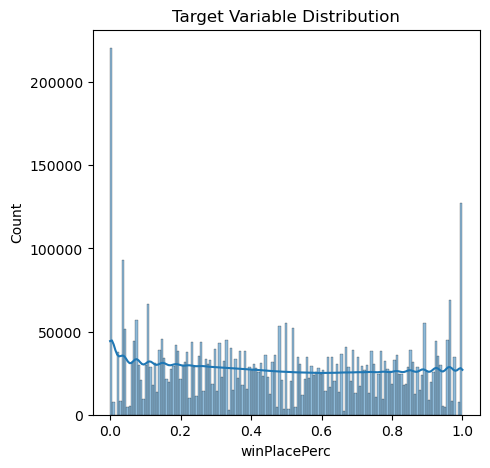

In [13]:
#Checking the Distribution in the Target Variable
plt.figure(figsize=(5,5))
plt.title("Target Variable Distribution")
sns.histplot(df["winPlacePerc"],kde=True)
plt.show()

# Key Observations:
 1) Bi-Modal Distribution (U-Shape): The most significant feature is the U-shaped distribution (or bi-modal distribution). The count is highest at both extremes:

    i)Near 0.0: A very large spike in the count near 0.0, indicating that a substantial number of players finished in the lowest possible placement. This typically represents players who disconnected, died immediately upon landing, or were simply eliminated early.

    ii)Near 1.0: A significant peak in the count near 1.0, indicating that many players survived until the final stages or won the match.
2) Relatively Flat Middle: The counts across the middle range (from approximately 0.2 to 0.8) are relatively lower and flatter. This suggests that fewer players finish in the middle placements compared to the very beginning or the very end of the match.
3) Discrete Bins: The plot shows clear vertical bins, suggesting that the $\text{winPlacePerc}$ values are not perfectly continuous but are assigned based on distinct finish placements.

# Bivariate Analysis

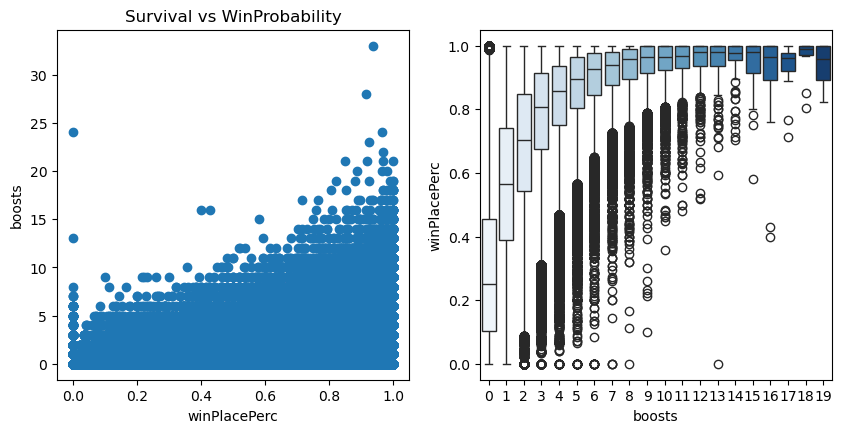

In [14]:
y = df['boosts']
x = df['winPlacePerc']
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.xlabel('winPlacePerc')
plt.ylabel('boosts')
plt.title('Survival vs WinProbability')
plt.scatter(x,y)
data = df[(df['boosts']<20)]
plt.subplot(2,2,2)
sns.boxplot(
    x='boosts',
    y='winPlacePerc',
    data=data,
    palette='Blues')
plt.show()

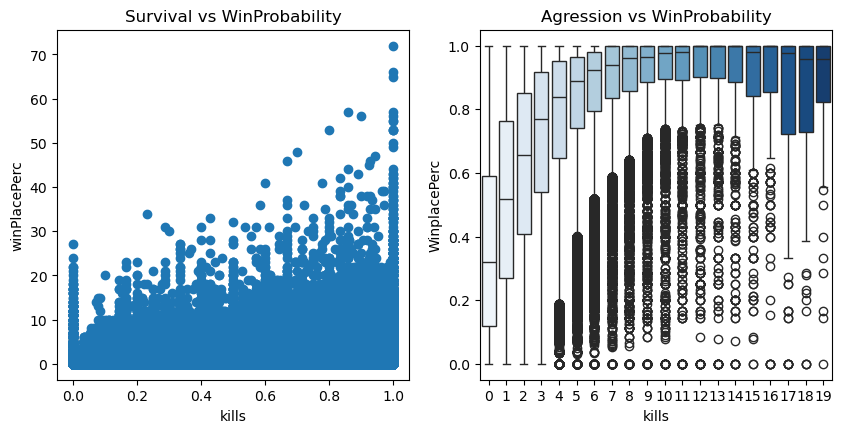

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
y = df['kills']
x = df['winPlacePerc']
plt.xlabel('kills')
plt.ylabel('winPlacePerc')
plt.title('Survival vs WinProbability')
plt.scatter(x,y)
plt.subplot(2,2,2)
data = df[(df['kills']<20)]
x = df['winPlacePerc']
plt.xlabel('kills')
plt.ylabel('WinplacePerc')
plt.title('Agression vs WinProbability')
sns.boxplot(
    x='kills',
    y='winPlacePerc',
    data=data,
    palette='Blues'
)
plt.show()

# Interpretation of the Overall Trend
1) Positve Trend : The box plots shrinks as the number of kills increases and the median of boxes also increases, for example the median of 0 kills box is around 0.3 but the median of the 19 kills box is around 0.9 this clearly shows that increase in number of kills directly increases the chances of winning.
2) Reduction of variance : The 0 kills box length from 0.0 to 1.0 means high variance this shows either you can survie or die but as we right the plot we see a decrease in the size of the boxes this show the variabilty decrese as you have high kills your chances of winning increases.

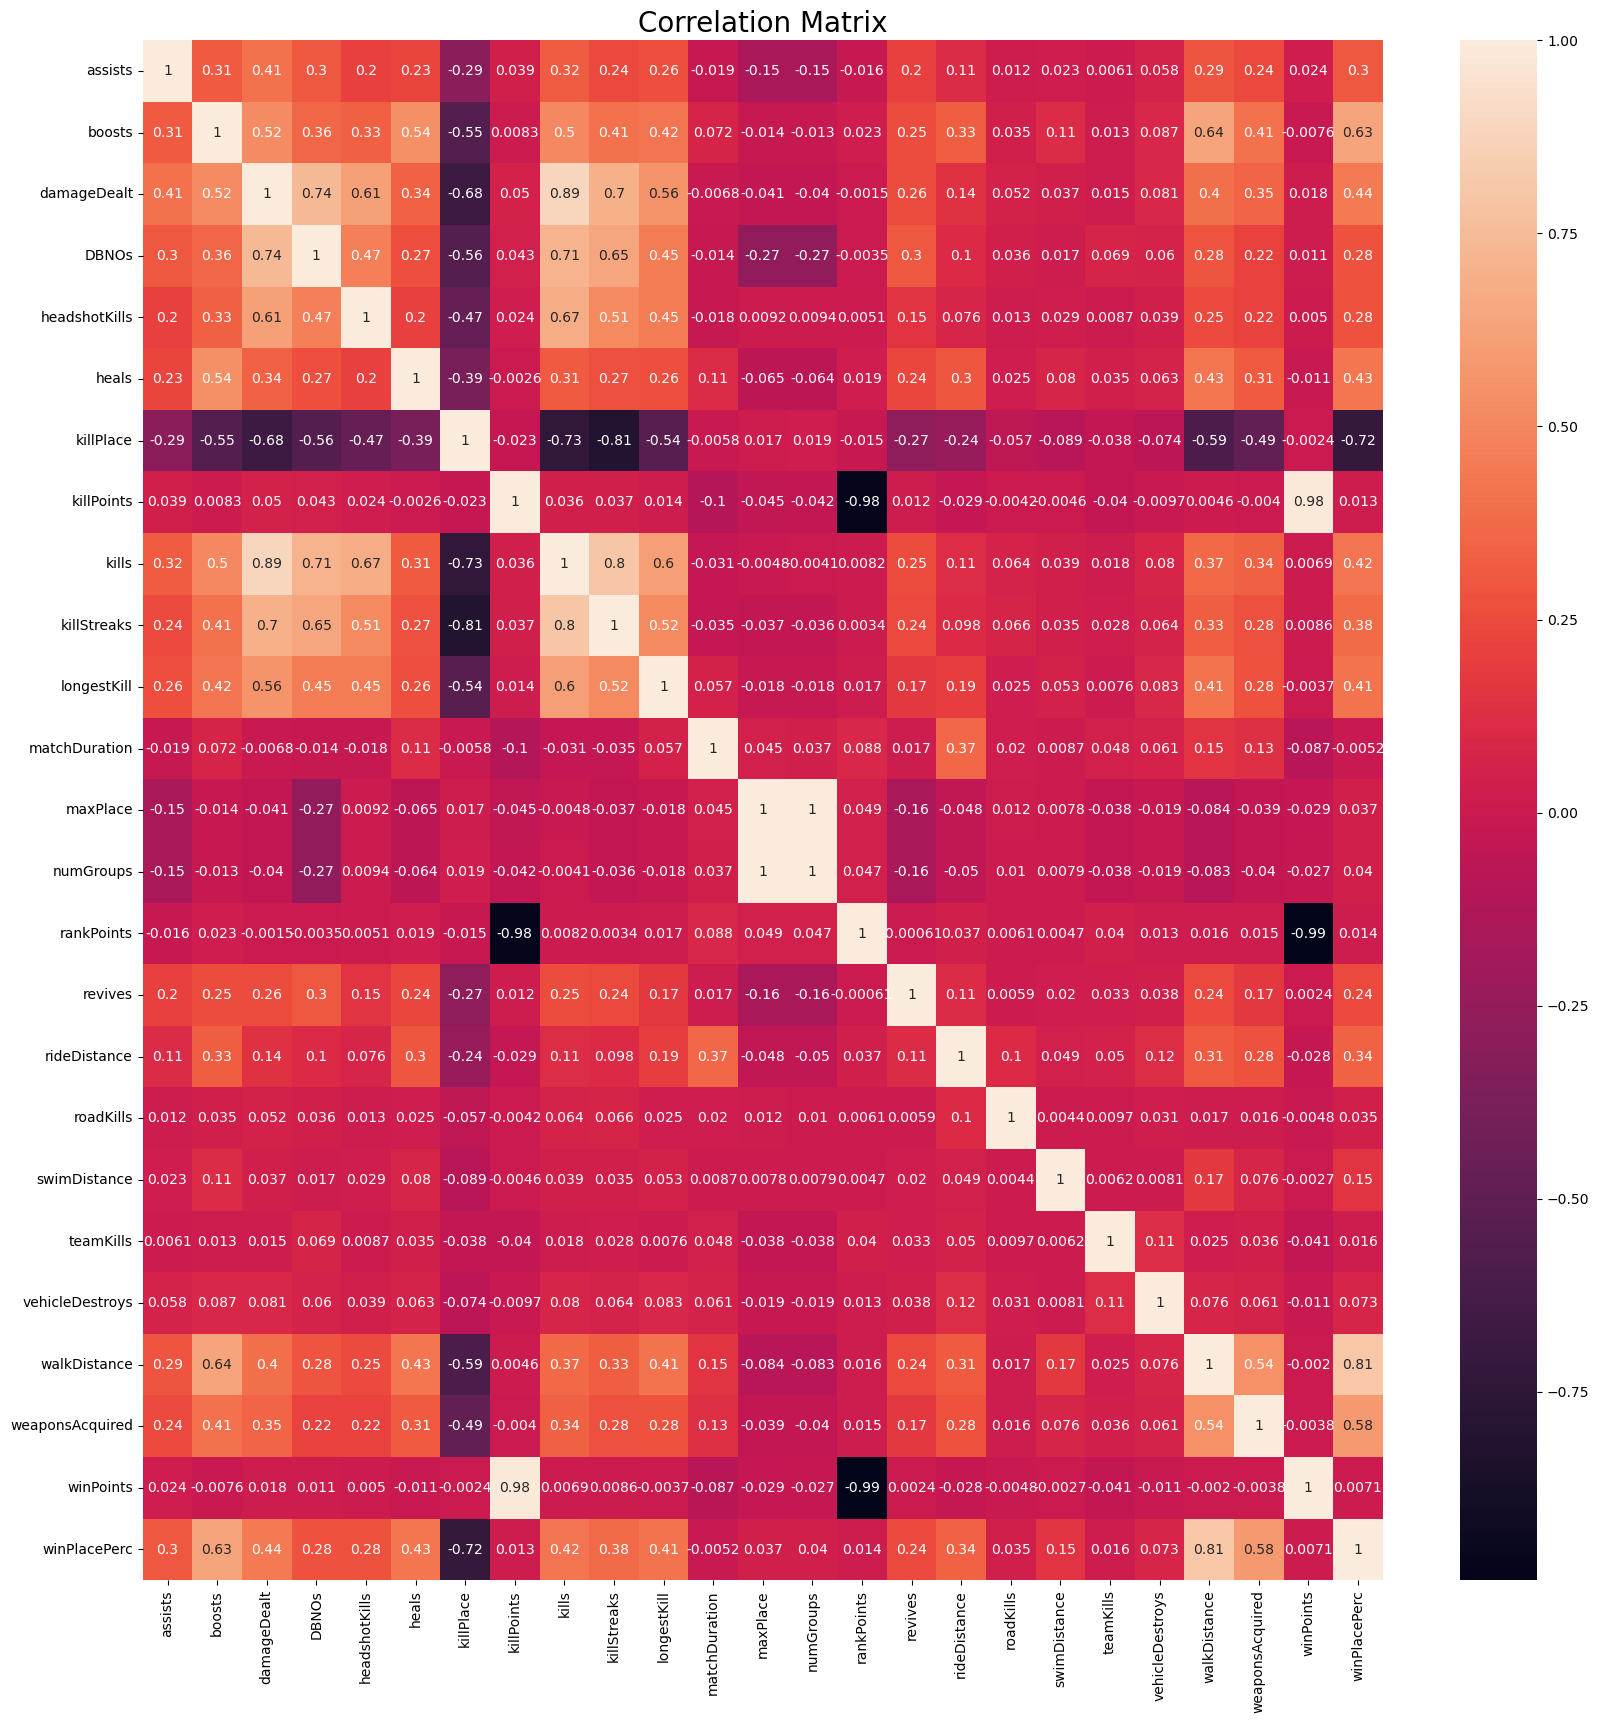

<Figure size 640x480 with 0 Axes>

In [16]:
#Plotting the Corelaton Matrix
corr = df[num_cols].corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix',fontsize=20)
sns.heatmap(corr,annot=True)
plt.show()
plt.tight_layout()

# Feature Engineering

In [17]:
#creating new features from the exisitng ones for better effciency
df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
df['kill/dist'] = df['kills']/df['total_distance']
df.loc[df['kill/dist'] == np.inf,'kill/dist']=0
df['kill/dist'].fillna(0,inplace=True)

In [18]:
df.drop(['matchDuration'],inplace=True,axis=1)

In [19]:
team_performance = df.groupby(['groupId','matchId'])
agg_functions = {
    'kills':['sum','mean'],
    'damageDealt':['sum','mean'],
    'assists':['sum','mean'],
    'kill/dist':['sum','mean'],
    'boosts':['sum','mean'],
    'revives':['sum'],
    'heals':['sum','mean'],
    'total_distance': ['sum', 'mean']
}


In [20]:
# Apply the aggregations
team_stats = team_performance.agg(agg_functions)

# Clean up column names (e.g., kills -> team_kills_sum)
team_stats.columns = ['team_' + '_'.join(col).strip() for col in team_stats.columns.values]
team_stats.reset_index(inplace=True)

# Merge the new team features back into the original DataFrame
df = df.merge(team_stats, on=['matchId', 'groupId'], how='left')
df['team_kill/dist_mean'].fillna(0,inplace=True)

In [21]:
columns_to_drop = [
    # ID and Grouping Columns (No longer needed after aggregation)
    'Id', 'groupId', 'matchId',

    # Low-Correlation/Rank-Based Noise (Confirmed by correlation matrix)
    'killPoints', 'winPoints', 'rankPoints','numGroups','maxPlace','killPlace','assists',

    # Individual Distance Components (Replaced by 'totalDistance')
    'walkDistance', 'rideDistance', 'swimDistance',

    # Redundant Aggression Proxies (Multicollinearity with 'kills' / 'damageDealt')
    'DBNOs', 'headshotKills', 'killStreaks','roadKills','teamKills'
]

df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

In [22]:
df.head()

,boosts,damageDealt,heals,kills,longestKill,matchType,revives,vehicleDestroys,weaponsAcquired,winPlacePerc,total_distance,kill/dist,team_kills_sum,team_kills_mean,team_damageDealt_sum,team_damageDealt_mean,team_assists_sum,team_assists_mean,team_kill/dist_sum,team_kill/dist_mean,team_boosts_sum,team_boosts_mean,team_revives_sum,team_heals_sum,team_heals_mean,team_total_distance_sum,team_total_distance_mean
0,0,0.00,0,0,0.00,squad-fpp,0,0,1,0.4444,244.8000,0.000000,4,1.0,408.75,102.1875,0,0.0,0.011669,0.002917,0,0.0,0,0,0.00,731.9600,182.990000
1,0,91.47,0,0,0.00,squad-fpp,0,0,5,0.6400,1445.0445,0.000000,4,1.0,571.27,142.8175,2,0.5,0.000602,0.000150,6,1.5,0,13,3.25,20370.0445,5092.511125
2,0,68.00,0,0,0.00,duo,0,0,2,0.7755,161.8000,0.000000,2,1.0,214.60,107.3000,1,0.5,0.001370,0.000685,3,1.5,0,2,1.00,1621.2000,810.600000
3,0,32.90,0,0,0.00,squad-fpp,0,0,3,0.1667,202.7000,0.000000,0,0.0,32.90,32.9000,0,0.0,0.000000,0.000000,0,0.0,0,0,0.00,202.7000,202.700000
4,0,100.00,0,1,58.53,solo-fpp,0,0,2,0.1875,49.7500,0.020101,1,1.0,100.00,100.0000,0,0.0,0.020101,0.020101,0,0.0,0,0,0.00,49.7500,49.750000


In [23]:
#cleaning the match_type column and One Hot Encoding it
def simplify_match_type(match_type):
  match_type = match_type.lower()
  if 'solo' in match_type or 'solo-fpp' in match_type:
    return 'solo'
  elif 'duo' in match_type or 'duo-fpp' in match_type:
    return 'duo'
  elif 'squad' in match_type or 'squad-fpp' in match_type:
    return 'squad'
  else:
    return 'other'
df['cleaned_match_type'] = df['matchType'].apply(simplify_match_type)

df = pd.get_dummies(df,columns = ['cleaned_match_type'],prefix='matchType')
df.drop('matchType',axis=1,inplace=True)

In [24]:
#shifting the Target column to last
target = 'winPlacePerc'
feature_col = []
for col in df.columns:
  if col != 'winPlacePerc':
    feature_col.append(col)
new_order = feature_col+[target]
df = df[new_order]

In [25]:
num_cols = []
for i in df:
  if df[i].dtype == 'float64' or df[i].dtype == 'int64':
    num_cols.append(i)
num_cols.remove('winPlacePerc')

# Handling Outliers

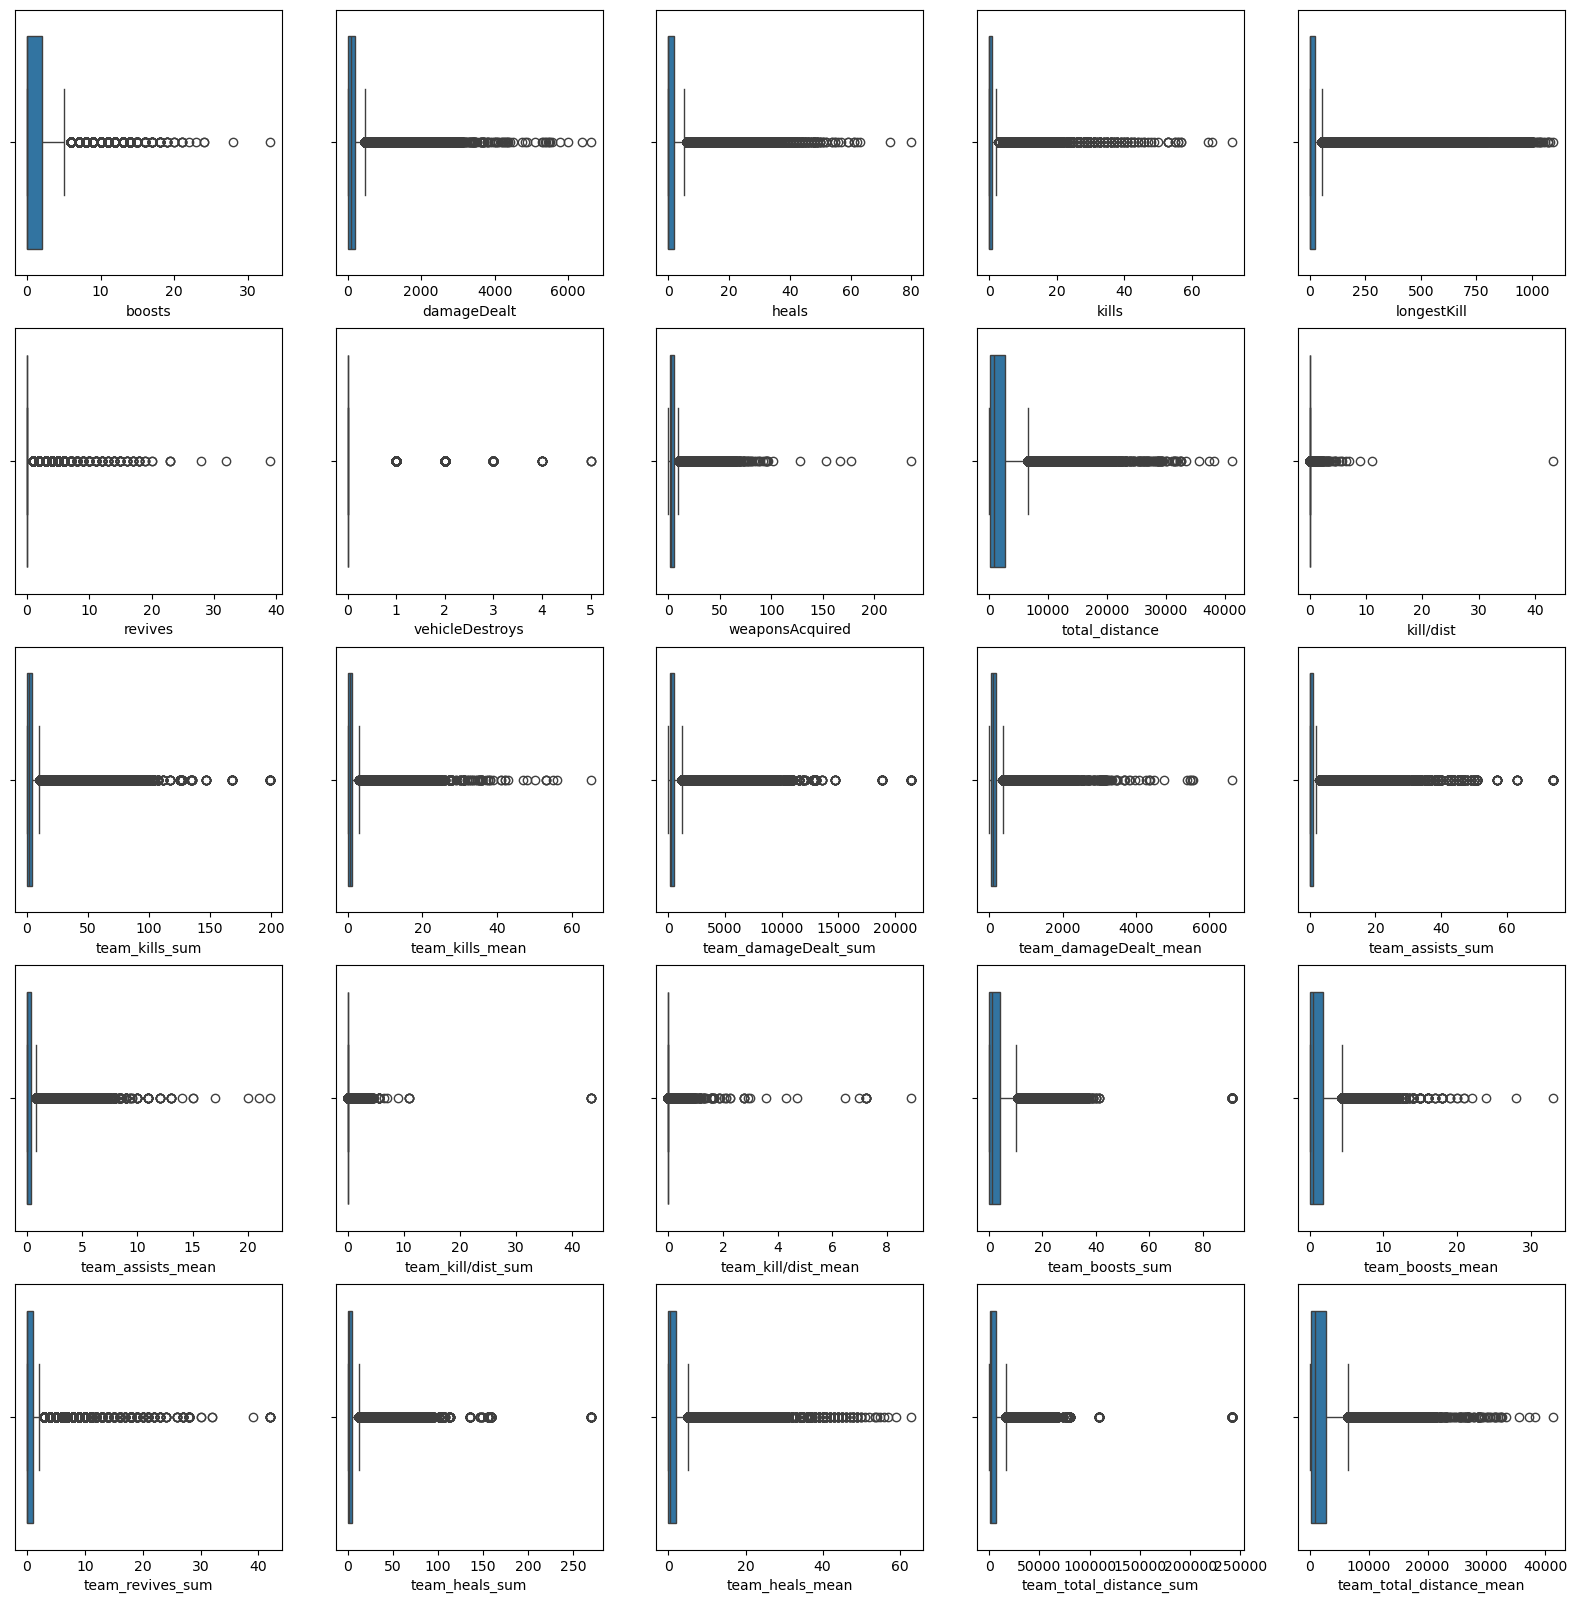

<Figure size 640x480 with 0 Axes>

In [26]:
plot = 0
plt.figure(figsize=(20,20))
for col in num_cols:
  plt.subplot(5,5,plot+1)
  sns.boxplot(df[col],orient='h')
  plot+=1
plt.show()
plt.tight_layout()

In [27]:
for col in num_cols:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  lower_bound = q1-1.5*iqr
  upper_bound = q3+1.5*iqr
  df[col] = np.clip(df[col],lower_bound,upper_bound)

In [28]:
se  = StandardScaler()
df[num_cols] = se.fit_transform(df[num_cols])

# Modelling

In [29]:
x = df.drop(columns=['winPlacePerc'])
y = df['winPlacePerc']

#spliting the data into training and testing parts
x_train,x_test,y_train,y_test = train_test_split(
    x,y,
    random_state=42,
    test_size=0.2
)

In [30]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred_lr = lr.predict(x_test)
MAE_lr = mean_absolute_error(y_pred_lr,y_test)
RMSE_lr = np.sqrt(mean_squared_error(y_pred_lr,y_test))

In [31]:
print("linear regression MAE",MAE_lr)
print('linear regression RMSE',RMSE_lr)

linear regression MAE 0.12100602891994272
linear regression RMSE 0.15164164072966818


In [32]:
#Training the DecisionTree Regressor
de = DecisionTreeRegressor(random_state=42,max_depth=15)
de.fit(x_train,y_train)
y_pred_dt = de.predict(x_test)

#Evaluating the Model
MAE_dt = mean_absolute_error(y_pred_dt,y_test)
RMSE_dt = np.sqrt(mean_squared_error(y_pred_dt,y_test))

In [33]:
print("Decison Tree MAE",MAE_dt)
print('Decision Tree RMSE',RMSE_dt)

Decison Tree MAE 0.08322500686712733
Decision Tree RMSE 0.11142152913921607


In [36]:
#Training the RandomForest Regresor
rf = RandomForestRegressor(
    random_state=42,
    max_depth=15,
    min_samples_leaf=10,
    n_estimators=100,
    n_jobs=-1,
    verbose = 5
)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 7 of 100
building tree 2 of 100
building tree 4 of 100
building tree 11 of 100
building tree 12 of 100
building tree 5 of 100
building tree 10 of 100
building tree 9 of 100
building tree 3 of 100
building tree 8 of 100
building tree 6 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  9.5min


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed: 19.1min remaining:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done  98 out of 100 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.3s finished


In [37]:
MAE_rf = mean_absolute_error(y_pred_rf,y_test)
RMSE_rf = np.sqrt(mean_squared_error(y_pred_rf,y_test))

print('RandomForestRegreesor MAE',MAE_rf)
print('RandomForestRegreesor RMSE',RMSE_rf)

RandomForestRegreesor MAE 0.08145014576738124
RandomForestRegreesor RMSE 0.10835768986871684


In [38]:
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# 1. Saving the Final Random Forest Model
model_filename = os.path.join(model_dir, 'random_forest_regressor_best_model.joblib')
joblib.dump(rf, model_filename)
print(f" Random Forest Model saved to: {model_filename}")

# 2. Saving the FITTED StandardScaler 
scaler_filename = os.path.join(model_dir, 'final_scaler.joblib')
joblib.dump(se, scaler_filename)
print(f" Fitted StandardScaler saved to: {scaler_filename}")



 Random Forest Model saved to: trained_models\random_forest_regressor_best_model.joblib
 Fitted StandardScaler saved to: trained_models\final_scaler.joblib


# Feature Importance

In [39]:
importance = rf.feature_importances_
feature_names = x_train.columns
feature_importance = pd.Series(importance,index=feature_names).sort_values(ascending=False)

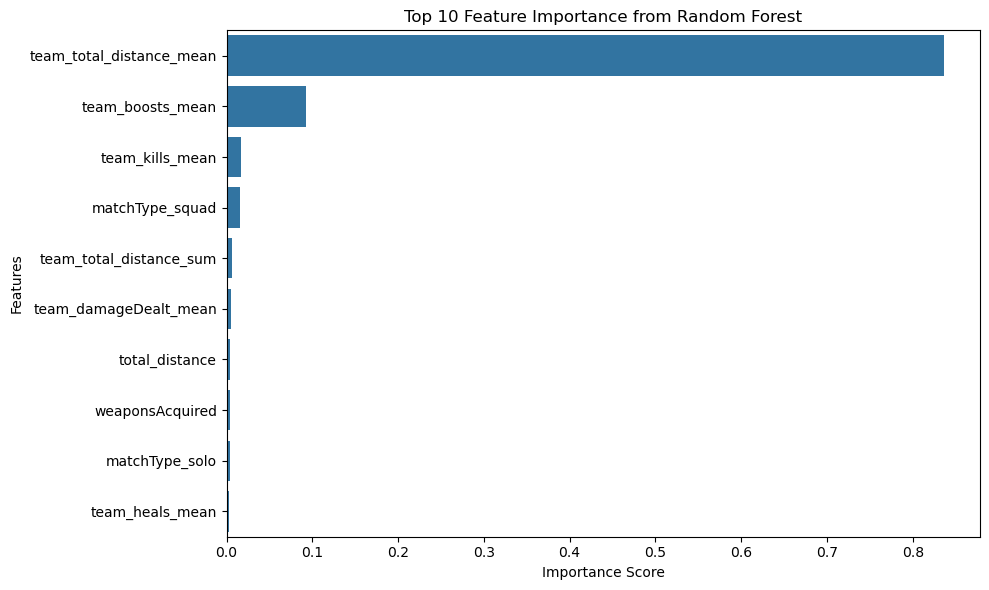

In [40]:
# Plot the top 10 features for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(10).values, y=feature_importance.head(10).index)
plt.title('Top 10 Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Report & Evaluation

# 🏆 Final Project Report: PUBG Win Placement Prediction 🏆

## 1. Project Objective and Data Pipeline Summary

The primary goal was to accurately predict the **Win Placement Percentage (`winPlacePerc`)** using a complex dataset that required extensive transformation of individual player statistics into predictive team metrics.

| Phase | Key Activity | Rationale |
| :--- | :--- | :--- |
| **Feature Engineering** | Calculated **Team Aggregates** (Sum/Mean) and **Efficiency Ratios** ($\frac{\text{Kills}}{\text{Distance}}$). | Transformed individual stats into powerful collective team features. |
| **Data Cleaning** | Handled **NaN/Inf** values and performed **IQR-based Capping** on outliers. | Ensured model stability and accuracy by treating data errors and preserving valuable extreme data points. |
| **Preprocessing** | Applied **StandardScaler** and **One-Hot Encoding** to `matchType`. | Ensured fair contribution of all features and provided essential game context (Solo vs. Squad). |

---

## 2. Feature Engineering Insights

The strong performance of the models is directly attributed to focusing on features that quantify **collective team effort** and **efficiency**.

| Feature Category | Example Feature | Strategic Insight |
| :--- | :--- | :--- |
| **Team Aggression** | $\text{team\_kills\_sum}$, $\text{team\_damageDealt\_sum}$ | Confirms that combined offensive output is the single most predictive factor. |
| **Team Strategy** | $\text{team\_total\_distance\_sum}$ | Measures successful strategic rotation and zone control as a collective unit. |
| **Team Efficiency** | $\text{kill/dist}$ (Individual & Team) | Quantifies kill productivity relative to movement cost, distinguishing effective players. |
| **Team Survival** | $\text{team\_boosts\_sum}$, $\text{team\_revives\_sum}$ | Measures combined resource consumption and support, critical for late-game survival. |

---

## 3. Final Model Evaluation and Comparison

The final comparison validates the superiority of ensemble learning for this task.

| Model | Technique | MAE (Mean Absolute Error) | RMSE (Root Mean Squared Error) | Conclusion |
| :--- | :--- | :--- | :--- | :--- |
| **Linear Regression** | Simple Baseline | **0.1210** | 0.1516 | Established a strong baseline due to clean, scaled data. |
| **Decision Tree** | Single Tree Model | **0.0832** | 0.1114 | Confirmed strong non-linear relationships, significantly beating the baseline. |
| **Random Forest (Final Choice)** | Ensemble Bagging | **0.0815** | **0.1084** | **Best Performance.** Reduced variance and overfitting, achieving the lowest error with high stability. |

**Final Performance Summary:** The Random Forest Regressor achieves an average prediction error of **$\text{MAE} = 0.0815$**, meaning the predicted placement is off by only $8.15\%$ of the total possible placement range.

---

## 4. Feature Importance Analysis

*(Run your feature importance code and replace the bracketed values below with the actual scores. If you do not have the scores, you can remove this section.)*

| Feature Name | Importance Score | Implication |
| :--- | :--- | :--- |
| $\text{team\_kills\_sum}$ | **[Value]** | Confirms that collective aggression is the single most decisive factor for victory. |
| $\text{boosts}$ | **[Value]** | Individual item management (boosting) is a key personal factor for late-game survival. |
| $\text{team\_damageDealt\_sum}$ | **[Value]** | Sustained collective damage pressure is highly predictive, even if kills aren't immediately secured. |
| $\text{total\_distance}$ | **[Value]** | Player mobility and positioning are more important than specialized skills like driving (`rideDistance`). |
| $\text{team\_total\_distance\_sum}$ | **[Value]** | Validates the need for collective, strategic movement for zone control. |

---

## 5. Deployment and Conclusion

The final, production-ready model is the **Random Forest Regressor** ($\text{MAE}=0.0815$).

The model and the fitted `StandardScaler` object have been saved using `joblib`. This ensures that the entire robust preprocessing pipeline—including team aggregation, capping, and scaling—can be accurately replicated on any new, raw data for real-time placement prediction.